In [1]:
# ================================================================================ #
# =========================== Goolge Colab File Upload =========================== #
# ================================================================================ #

from google.colab import drive
drive.mount('/content/drive')

from google.colab import output
# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/drive/MyDrive/Colab Notebooks/동서발전 태양광 발전량 예측 경진대회/data.zip" "data.zip"
# data.zip을 현재 디렉터리에 압축해제
!unzip "data.zip"
output.clear()

import os


# path
path = "./"
dangjin_fcst_data_path = path + "dangjin_fcst_data.csv"
dangjin_obs_data_path = path + "dangjin_obs_data.csv"
energy_data_path = path + "energy.csv"
ulsan_fcst_data_path = path + "ulsan_fcst_data.csv"
ulsan_obs_data_path = path + "ulsan_obs_data.csv"
site_info_path = path + "site_info.csv"

# import library 
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
#import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os
import glob

# file convert to pandas data
dangjin_fcst_data = pd.read_csv(dangjin_fcst_data_path)
dangjin_obs_data = pd.read_csv(dangjin_obs_data_path)
energy_data = pd.read_csv(energy_data_path)
ulsan_fcst_data = pd.read_csv(ulsan_fcst_data_path)
ulsan_obs_data = pd.read_csv(ulsan_obs_data_path)
site_info = pd.read_csv(site_info_path)

In [2]:

dangjin_fcst_data.rename(
    columns = {
        "Forecast time":"time", 
        "forecast":"forecast_fcst", 
        "Temperature":"temp_fcst",
        "Humidity":"humid_fcst",
        "WindSpeed":"ws_fcst",
        "WindDirection":"wd_fcst",
        "Cloud":"cloud_fcst"
        }, inplace = True)

dangjin_obs_data.rename(
    columns = {
        "일시":"time",
        "기온(°C)":"temp_obs",
        "풍속(m/s)":"ws_obs",
        "풍향(16방위)":"wd_obs",
        "습도(%)":"humid_obs",
        "전운량(10분위)":"cloud_obs"
    }, inplace = True)

ulsan_fcst_data.rename(
    columns = {
        "Forecast time":"time", 
        "forecast":"forecast_fcst", 
        "Temperature":"temp_fcst",
        "Humidity":"humid_fcst",
        "WindSpeed":"ws_fcst",
        "WindDirection":"wd_fcst",
        "Cloud":"cloud_fcst"
    }, inplace = True)

ulsan_obs_data.rename(
    columns = {
        "일시":"time",
        "기온(°C)":"temp_obs",
        "풍속(m/s)":"ws_obs",
        "풍향(16방위)":"wd_obs",
        "습도(%)":"humid_obs",
        "전운량(10분위)":"cloud_obs"
    }, inplace = True)

dangjin_obs_data = dangjin_obs_data.drop(columns = ["지점", "지점명"])
ulsan_obs_data = ulsan_obs_data.drop(columns = ["지점","지점명"])

# fcst_data 데이터 전처리
# time + forecast -> time으로 전환, 이후 중복되는 값은 평균 처리 

dangjin_fcst_data["time_fcst"] = pd.to_datetime(dangjin_fcst_data["time"].copy()) + dangjin_fcst_data["forecast_fcst"].copy().astype("timedelta64[h]")
dangjin_fcst_data = dangjin_fcst_data.groupby("time_fcst", as_index = False).mean()
dangjin_fcst_data = dangjin_fcst_data.drop(columns = ["forecast_fcst"])

ulsan_fcst_data["time_fcst"] = pd.to_datetime(ulsan_fcst_data["time"].copy()) + ulsan_fcst_data["forecast_fcst"].copy().astype("timedelta64[h]")
ulsan_fcst_data = ulsan_fcst_data.groupby("time_fcst", as_index = False).mean()
ulsan_fcst_data = ulsan_fcst_data.drop(columns = ["forecast_fcst"])

ulsan_fcst_data.rename(columns = {"time_fcst":"time"}, inplace = True)
dangjin_fcst_data.rename(columns = {"time_fcst":"time"}, inplace = True)

ulsan_fcst_data = ulsan_fcst_data.astype({"time":"object"})
dangjin_fcst_data = dangjin_fcst_data.astype({"time":"object"})

dangjin_obs_data["time"] = pd.to_datetime(dangjin_obs_data["time"].copy(), format='%Y-%m-%d %H:%M:%S')
dangjin_obs_data = dangjin_obs_data.astype({"time":"object"})

ulsan_obs_data["time"] = pd.to_datetime(ulsan_obs_data["time"].copy(), format='%Y-%m-%d %H:%M:%S')
ulsan_obs_data = ulsan_obs_data.astype({"time":"object"})

# energy_data는 time 항목이 string으로 저장되어 있다. 이를 timestamp로 처리해야한다. 

import datetime as dt

energy_data_time_tmp = energy_data["time"].copy()

for i in range(energy_data.shape[0]):
    if energy_data["time"][i][-8:] == "24:00:00":
        energy_data["time"][i] = energy_data_time_tmp[i].replace("24:00:00", " 00:00:00")
        energy_data["time"][i] = pd.to_datetime(energy_data["time"][i]) + dt.timedelta(days = 1)

    energy_data["time"][i] = pd.Timestamp(energy_data["time"][i])

energy_data = energy_data.astype({"time":"object"})

# 전 데이터 NAN 처리

dangjin_fcst_data = dangjin_fcst_data.fillna(method = "bfill")
dangjin_obs_data = dangjin_obs_data.fillna(method = "bfill")
energy_data = energy_data.fillna(method = "bfill")
ulsan_fcst_data = ulsan_fcst_data.fillna(method = "bfill")
ulsan_obs_data = ulsan_obs_data.fillna(method = "bfill")

# fcst_data['time'] time interval: 3hour -> 1hour로 축소 필요
# Lagrangian Interpolation

def interpolation(df):

    df_copy = df.copy()
    var_names = df.columns

    total_s = list()
    time_list = list()
    
    for var_name in var_names:
        s = list()
        for i in range(df_copy.shape[0] - 1):
            timedeltas = df_copy["time"][i+1] - df_copy["time"][i]
            n_intervals = int(timedeltas / np.timedelta64(1, "h"))

            for j in range(n_intervals):
        
                if var_name == "time":
                    time_stamps = df_copy["time"][i] + timedeltas * j / n_intervals
                    time_list.append(time_stamps)
                else:
                    add_ = df_copy[var_name][i] + (df_copy[var_name][i+1] - df_copy[var_name][i]) / n_intervals * j
                    s.append(add_)

        if var_name == "time":
            time_list = np.array(time_list).reshape(-1,1)
            total_s.append(time_list)
        else:
            s = np.array(s).reshape(-1,1)
            total_s.append(s)

    total_s = np.array(total_s).T.reshape(-1, len(var_names))
    df_converted = pd.DataFrame(total_s, columns = var_names)

    return df_converted

dangjin_fcst_data = interpolation(dangjin_fcst_data.copy())
ulsan_fcst_data = interpolation(ulsan_fcst_data.copy())

ulsan_fcst_data = ulsan_fcst_data.astype({"time":"object"})
dangjin_fcst_data = dangjin_fcst_data.astype({"time":"object"})
energy_data = energy_data.astype({"time":"object"})
dangjin_obs_data = dangjin_obs_data.astype({"time":"object"})
ulsan_obs_data = ulsan_obs_data.astype({"time":"object"})

# total dataset 구성

from functools import reduce

list_dangjin = [dangjin_fcst_data, dangjin_obs_data, energy_data[["time","dangjin_floating","dangjin_warehouse","dangjin"]].copy()]
list_ulsan = [ulsan_fcst_data, ulsan_obs_data, energy_data[["time","ulsan"]].copy()]

dangjin_data = reduce(lambda  left,right: pd.merge(left, right, on=['time'], how='inner'), list_dangjin)
ulsan_data = reduce(lambda  left,right: pd.merge(left, right, on=['time'], how='inner'), list_ulsan)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


statistical analysis with dangjin_floating: pearson correlation coefficient
variable: temp_fcst, pearson's r : 0.253930, p-value: 0.000000
variable: humid_fcst, pearson's r : -0.579581, p-value: 0.000000
variable: ws_fcst, pearson's r : 0.041132, p-value: 0.000000
variable: wd_fcst, pearson's r : 0.112836, p-value: 0.000000
variable: cloud_fcst, pearson's r : -0.209831, p-value: 0.000000
variable: temp_obs, pearson's r : 0.306911, p-value: 0.000000
variable: ws_obs, pearson's r : 0.438486, p-value: 0.000000
variable: wd_obs, pearson's r : 0.344166, p-value: 0.000000
variable: humid_obs, pearson's r : -0.633038, p-value: 0.000000
variable: cloud_obs, pearson's r : -0.184812, p-value: 0.000000

statistical analysis with dangjin_warehouse: pearson correlation coefficient
variable: temp_fcst, pearson's r : 0.257077, p-value: 0.000000
variable: humid_fcst, pearson's r : -0.581035, p-value: 0.000000
variable: ws_fcst, pearson's r : 0.034766, p-value: 0.000000
variable: wd_fcst, pearson's r :

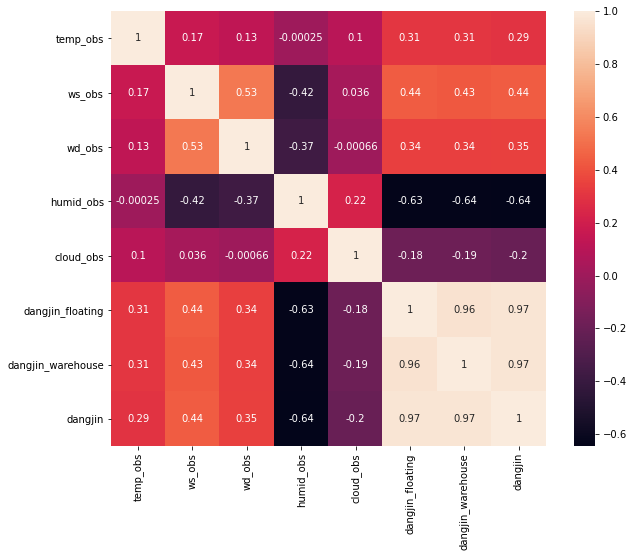

statistical analysis with ulsan: pearson correlation coefficient
variable: temp_fcst, pearson's r : 0.210539, p-value: 0.000000
variable: humid_fcst, pearson's r : -0.424667, p-value: 0.000000
variable: ws_fcst, pearson's r : 0.067494, p-value: 0.000000
variable: wd_fcst, pearson's r : -0.021578, p-value: 0.000553
variable: cloud_fcst, pearson's r : -0.194983, p-value: 0.000000
variable: temp_obs, pearson's r : 0.241035, p-value: 0.000000
variable: ws_obs, pearson's r : 0.307604, p-value: 0.000000
variable: wd_obs, pearson's r : -0.186940, p-value: 0.000000
variable: humid_obs, pearson's r : -0.447205, p-value: 0.000000
variable: cloud_obs, pearson's r : -0.213238, p-value: 0.000000



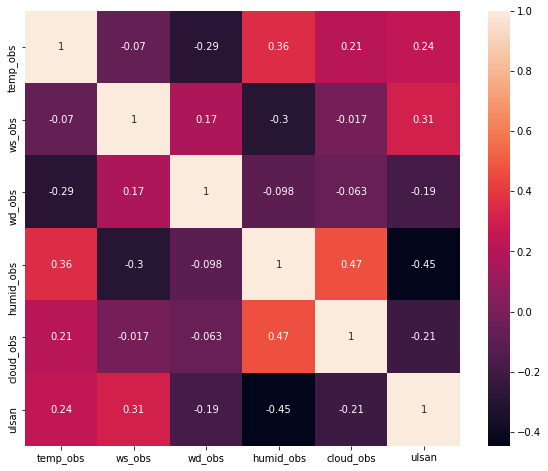

In [3]:
# EDA 
import seaborn as sns
from scipy import stats

var_names = dangjin_data.copy().drop(columns = ["dangjin_floating","dangjin_warehouse", "dangjin", "time"]).columns

print("statistical analysis with dangjin_floating: pearson correlation coefficient")
print("===========================================================================")
for var_name in var_names:
    r, p = stats.pearsonr(dangjin_data[var_name], dangjin_data["dangjin_floating"])
    log = "variable: %s, pearson's r : %5f, p-value: %5f"
    fmt = log %(var_name, r,p)
    print(fmt)
print("===========================================================================\n")
print("statistical analysis with dangjin_warehouse: pearson correlation coefficient")
print("===========================================================================")
for var_name in var_names:
    r, p = stats.pearsonr(dangjin_data[var_name], dangjin_data["dangjin_warehouse"])
    log = "variable: %s, pearson's r : %5f, p-value: %5f"
    fmt = log %(var_name, r,p)
    print(fmt)
print("===========================================================================\n")
print("statistical analysis with dangjin: pearson correlation coefficient")
print("===========================================================================")
for var_name in var_names:
    r, p = stats.pearsonr(dangjin_data[var_name], dangjin_data["dangjin"])
    log = "variable: %s, pearson's r : %5f, p-value: %5f"
    fmt = log %(var_name, r,p)
    print(fmt)
print("===========================================================================\n")

f, ax  = plt.subplots(figsize = (10, 8))
dangjin_corr = dangjin_data.corr("pearson")
sns.heatmap(dangjin_corr, mask = np.zeros_like(dangjin_corr, dtype = np.bool), square = True, annot = True, ax = ax)
plt.show()

# ulsan data

var_names = ulsan_data.copy().drop(columns = ["ulsan", "time"]).columns

print("statistical analysis with ulsan: pearson correlation coefficient")
print("===========================================================================")
for var_name in var_names:
    r, p = stats.pearsonr(ulsan_data[var_name], ulsan_data["ulsan"])
    log = "variable: %s, pearson's r : %5f, p-value: %5f"
    fmt = log %(var_name, r,p)
    print(fmt)
print("===========================================================================\n")

f, ax  = plt.subplots(figsize = (10, 8))
ulsan_corr = ulsan_data.corr("pearson")
sns.heatmap(ulsan_corr, mask = np.zeros_like(ulsan_corr, dtype = np.bool), square = True, annot = True, ax = ax)
plt.show()

                  time temp_fcst  ... dangjin_warehouse dangjin
0  2018-03-01 15:00:00         0  ...             496.0     672
1  2018-03-01 16:00:00 -0.666667  ...             391.0     546
2  2018-03-01 17:00:00  -1.33333  ...             271.0     364
3  2018-03-01 18:00:00        -2  ...              80.0     110
4  2018-03-01 19:00:00        -2  ...               2.0       0

[5 rows x 14 columns]


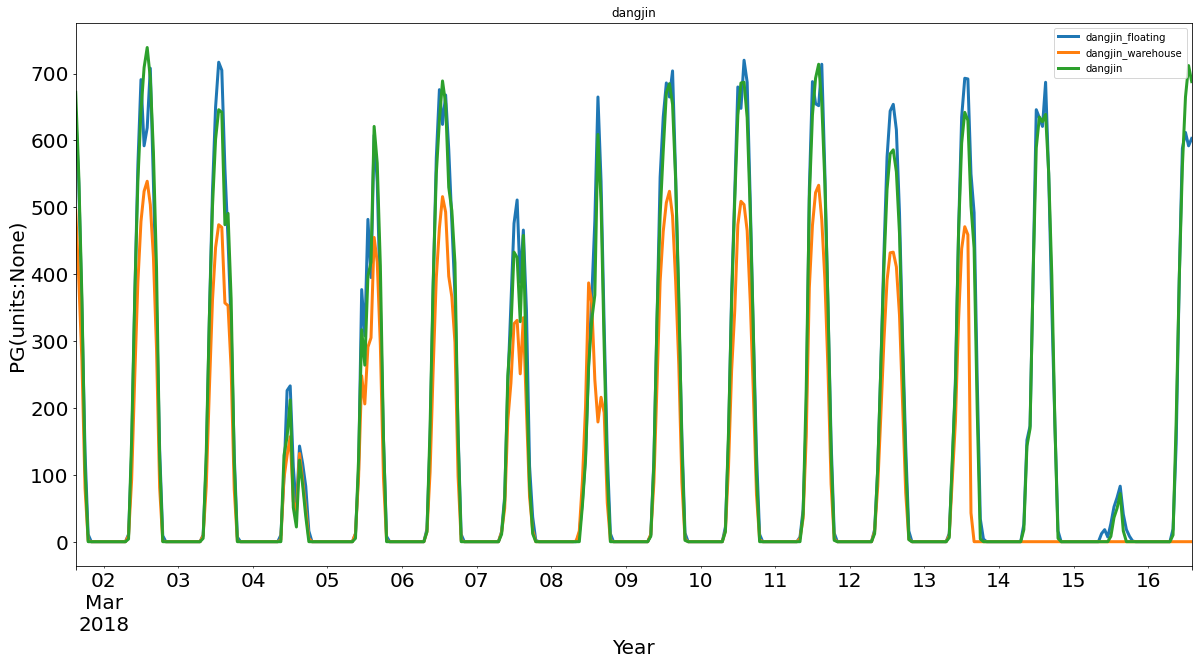

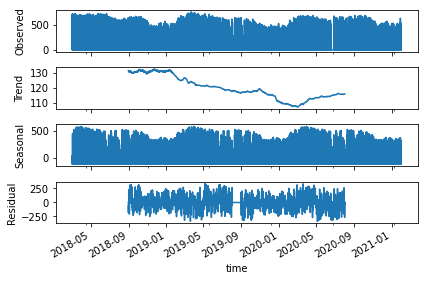

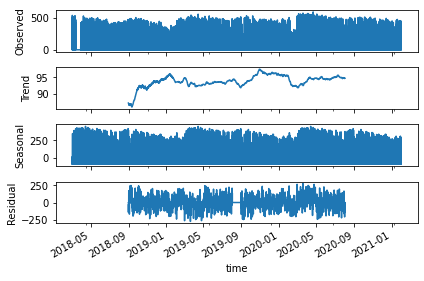

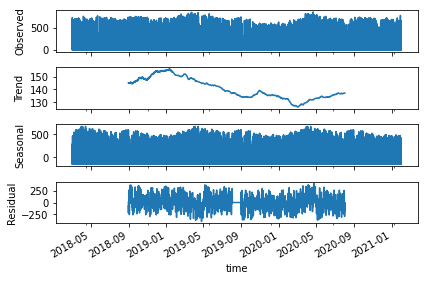

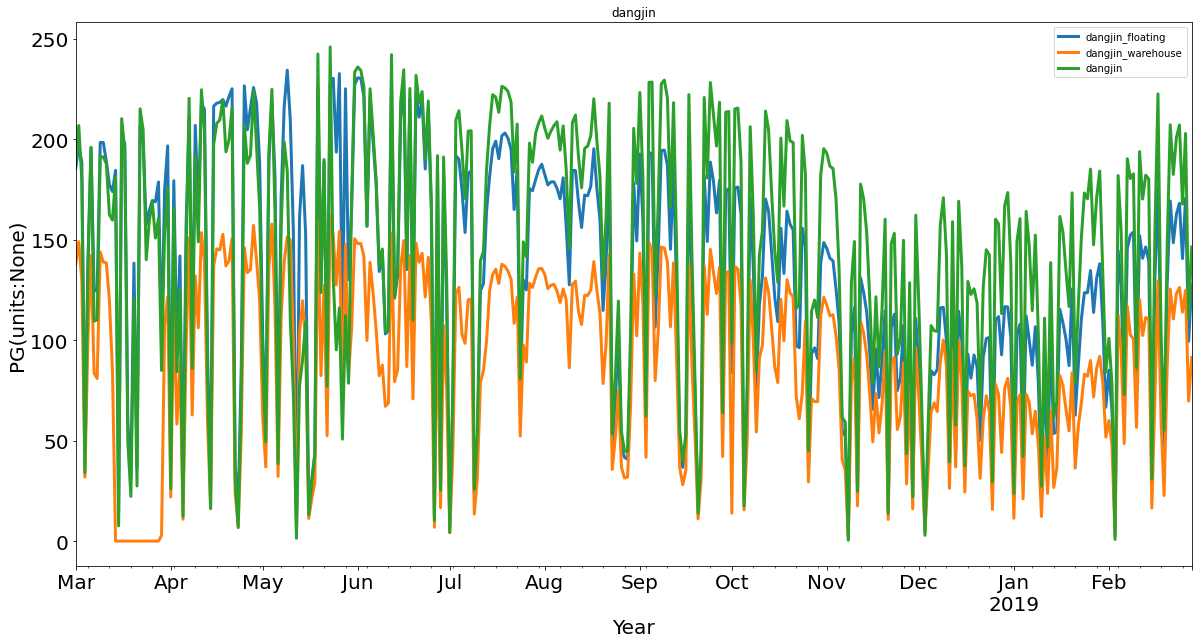

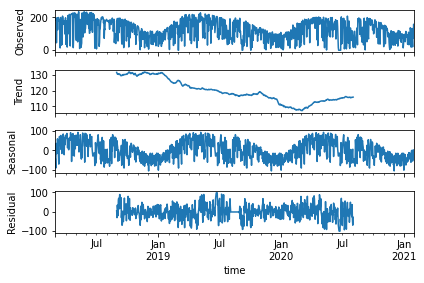

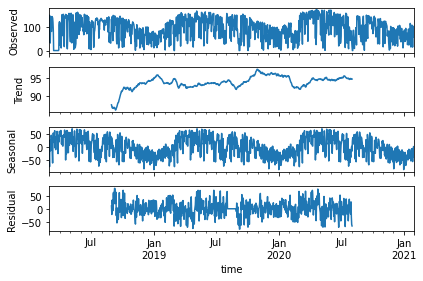

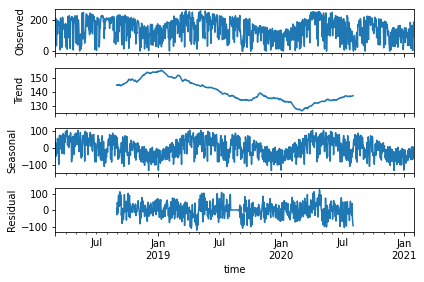

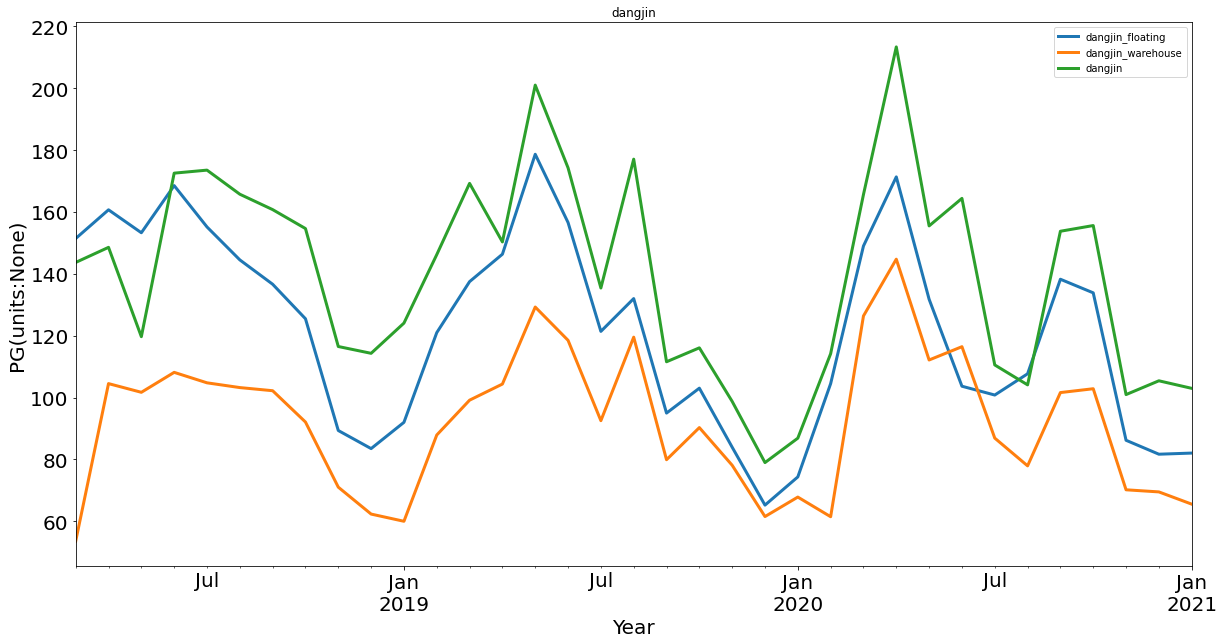

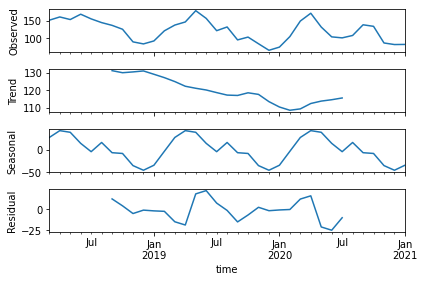

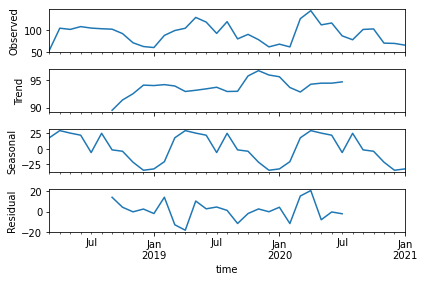

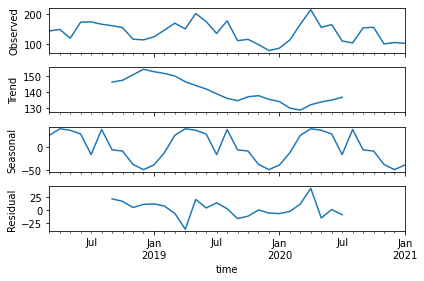

                  time temp_fcst humid_fcst  ... humid_obs cloud_obs ulsan
0  2018-03-01 15:00:00         8         20  ...      19.0       5.0   318
1  2018-03-01 16:00:00   6.66667         20  ...      17.0       1.0   258
2  2018-03-01 17:00:00   5.33333         20  ...      17.0       2.0   160
3  2018-03-01 18:00:00         4         20  ...      19.0       2.0    30
4  2018-03-01 19:00:00   3.66667    23.3333  ...      18.0       8.0     0

[5 rows x 12 columns]


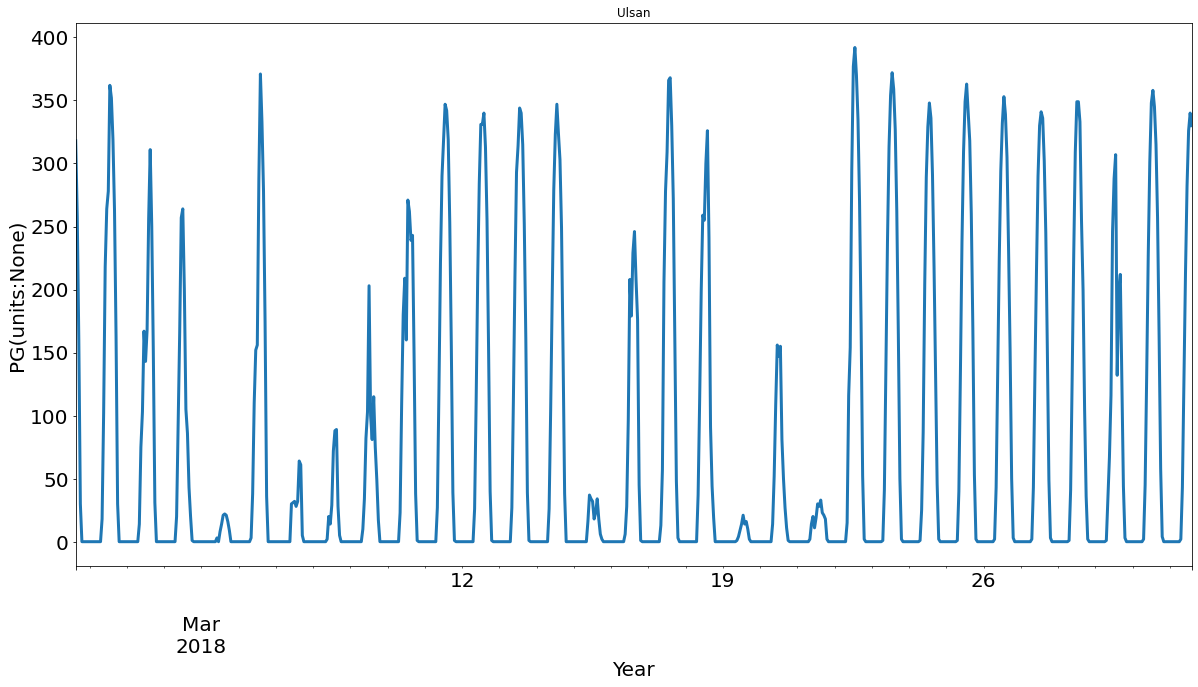

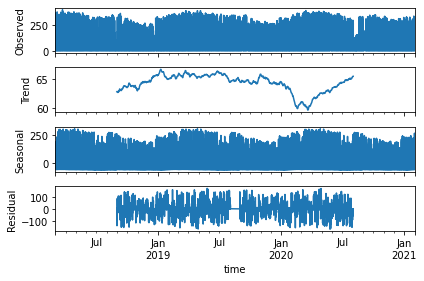

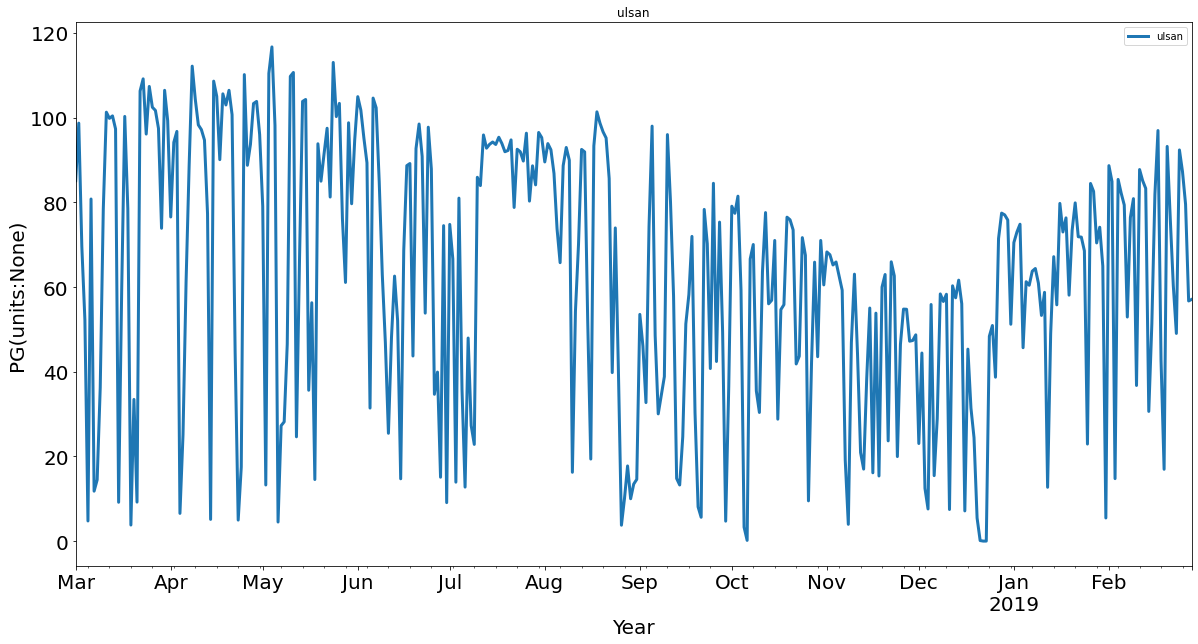

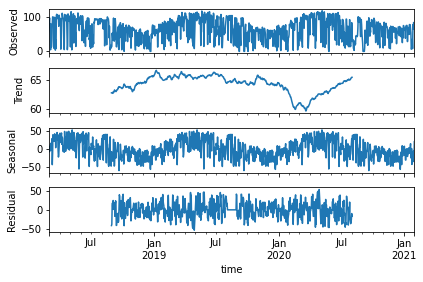

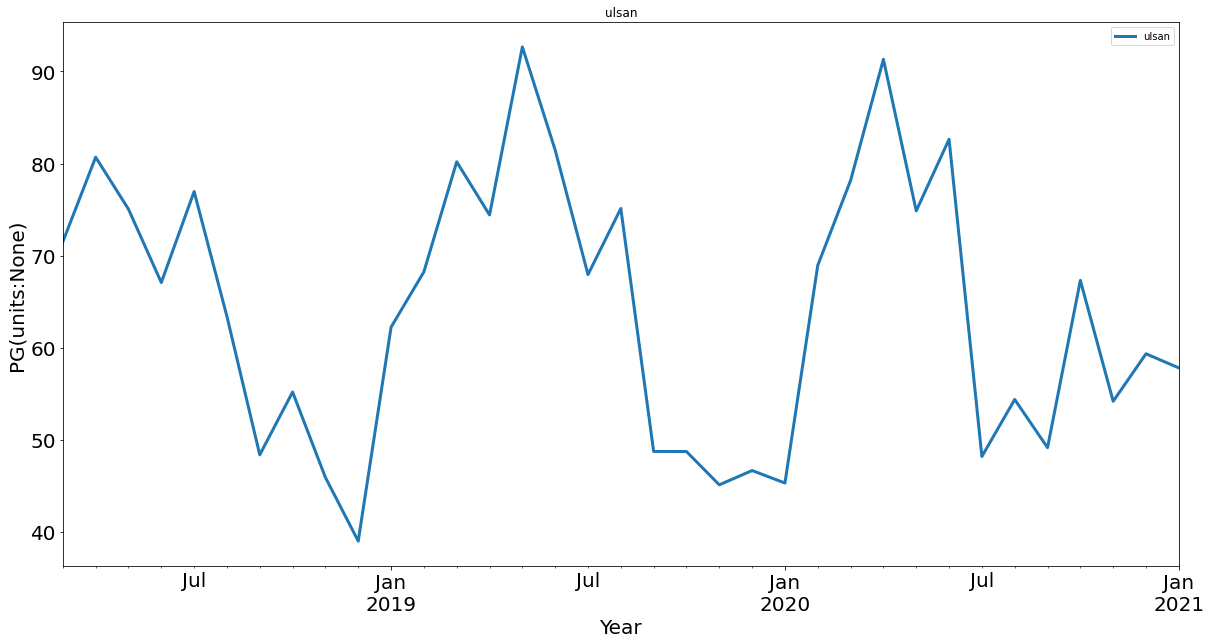

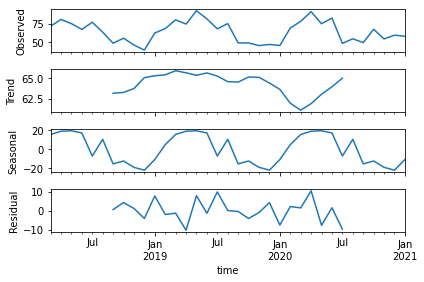

In [6]:
# trend, cyclic, seasonal data analysis

# dangjin_data
from statsmodels.tsa.seasonal import seasonal_decompose

print(dangjin_data.head())

df = dangjin_data.copy()
df.set_index("time", inplace = True)
df[["dangjin_floating", "dangjin_warehouse", "dangjin"]].iloc[0:15*24].plot(figsize = (20,10), linewidth = 3, fontsize = 20)
plt.xlabel("Year", fontsize = 20)
plt.ylabel("PG(units:None)", fontsize = 20)
plt.title("dangjin")
plt.show()

var_names = ["dangjin_floating", "dangjin_warehouse", "dangjin"]

# timesteps:hour
for name in var_names:
    result = seasonal_decompose(df[name], model = "additive", freq = 365 * 24)
    result.plot()
    plt.show()

# timesteps:day / groupby(day) + mean
df = dangjin_data.copy()
df_day = df.groupby(pd.Grouper(key = "time", freq = "24H")).mean()

df_day[["dangjin_floating", "dangjin_warehouse", "dangjin"]].iloc[0:365].plot(figsize = (20,10), linewidth = 3, fontsize = 20)
plt.xlabel("Year", fontsize = 20)
plt.ylabel("PG(units:None)", fontsize = 20)
plt.title("dangjin")
plt.show()

for name in var_names:
    result = seasonal_decompose(df_day[name], model = "additive", freq = 365)
    result.plot()
    plt.show()

# timesteps:month / groupby(month) + mean
df = dangjin_data.copy()
df_month = df.groupby(pd.Grouper(key = "time", freq = "M")).mean()

df_month[["dangjin_floating", "dangjin_warehouse", "dangjin"]].plot(figsize = (20,10), linewidth = 3, fontsize = 20)
plt.xlabel("Year", fontsize = 20)
plt.ylabel("PG(units:None)", fontsize = 20)
plt.title("dangjin")
plt.show()

for name in var_names:
    result = seasonal_decompose(df_month[name], model = "additive", freq = 12)
    result.plot()
    plt.show()

# for ulsan_data
print(ulsan_data.head())

df = ulsan_data.copy()
df.set_index("time", inplace = True)
df["ulsan"].iloc[0:30*24].plot(figsize = (20,10), linewidth = 3, fontsize = 20)
plt.xlabel("Year", fontsize = 20)
plt.ylabel("PG(units:None)", fontsize = 20)
plt.title("Ulsan")
plt.show()

var_names = ["ulsan"]

for name in var_names:
    result = seasonal_decompose(df[name], model = "additive", freq = 365 * 24)
    result.plot()
    plt.show()

# timesteps:day / groupby(day) + mean
df = ulsan_data.copy()
df_day = df.groupby(pd.Grouper(key = "time", freq = "24H")).mean()

df_day[["ulsan"]].iloc[0:365].plot(figsize = (20,10), linewidth = 3, fontsize = 20)
plt.xlabel("Year", fontsize = 20)
plt.ylabel("PG(units:None)", fontsize = 20)
plt.title("ulsan")
plt.show()

for name in var_names:
    result = seasonal_decompose(df_day[name], model = "additive", freq = 365)
    result.plot()
    plt.show()

# timesteps:month / groupby(month) + mean
df = ulsan_data.copy()
df_month = df.groupby(pd.Grouper(key = "time", freq = "M")).mean()

df_month[["ulsan"]].plot(figsize = (20,10), linewidth = 3, fontsize = 20)
plt.xlabel("Year", fontsize = 20)
plt.ylabel("PG(units:None)", fontsize = 20)
plt.title("ulsan")
plt.show()

for name in var_names:
    result = seasonal_decompose(df_month[name], model = "additive", freq = 12)
    result.plot()
    plt.show()